In [28]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [29]:
# Step 1: Load data
df = pd.read_excel("Sam's Fans All Transactions All Time (1).xlsx", parse_dates=["Date"])

# Step 2: Sort and engineer features
df.sort_values(by=["Account Number", "Date"], inplace=True)

# Step 3: Create features: total donations, recency, frequency
feature_df = df.groupby("Account Number").agg({
    "Date": ["min", "max", "count"],  # <- Fixed FutureWarnings by using strings
    "Revenue Amount": "sum"
})
feature_df.columns = ['first_donation', 'last_donation', 'frequency', 'total_amount']
feature_df['recency_days'] = (df['Date'].max() - feature_df['last_donation']).dt.days

# Step 4: Create label: did donor donate again within 90 days after a donation
retention_labels = []
for acc in df['Account Number'].unique():
    dates = df[df["Account Number"] == acc]["Date"].sort_values().tolist()
    retained = 0
    for i in range(len(dates) - 1):
        if (dates[i+1] - dates[i]).days <= 90:
            retained = 1
            break
    retention_labels.append(retained)

feature_df['retained'] = retention_labels

# Step 5: Prepare model data
X = feature_df[["frequency", "total_amount", "recency_days"]]
y = feature_df["retained"]

# Step 6: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Train model
model = XGBClassifier(eval_metric='logloss')  # Removed use_label_encoder to fix warning
model.fit(X_train, y_train)

# Step 8: Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.96      0.95       407
           1       0.84      0.80      0.82       116

    accuracy                           0.92       523
   macro avg       0.89      0.88      0.88       523
weighted avg       0.92      0.92      0.92       523



<Figure size 800x600 with 0 Axes>

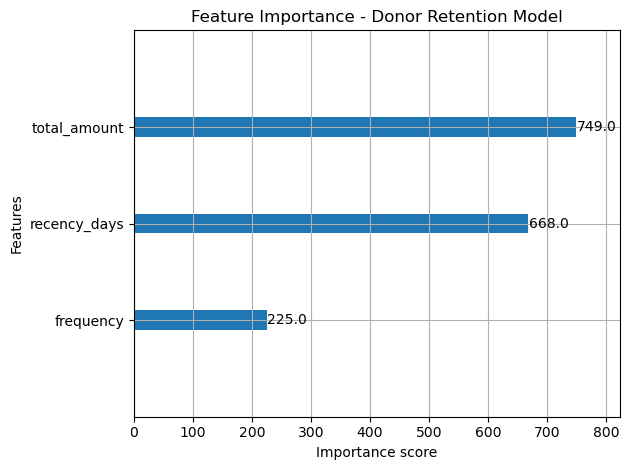

In [30]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(8, 6))
plot_importance(model)
plt.title("Feature Importance - Donor Retention Model")
plt.tight_layout()
plt.show()


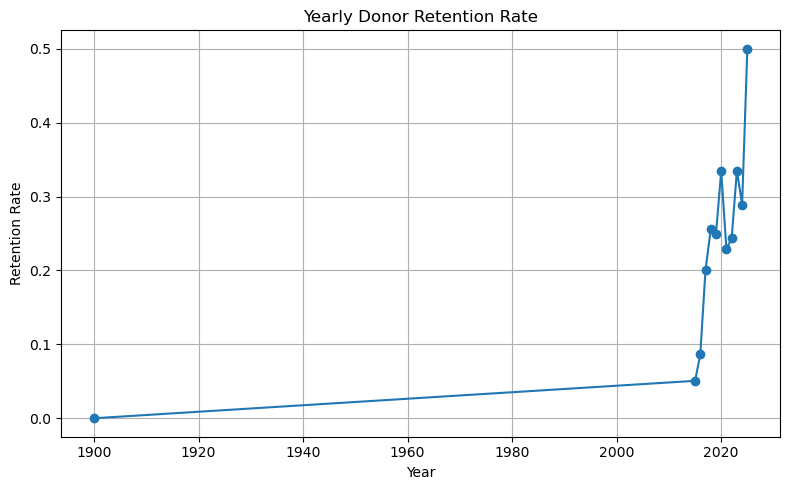

In [31]:
df['Year'] = df['Date'].dt.year

# Count retained donors per year
retention_df = df.groupby(['Year', 'Account Number']).size().reset_index(name='donation_count')
retention_df['retained'] = retention_df['donation_count'] > 1
retention_summary = retention_df.groupby('Year')['retained'].mean().reset_index()

# Plot retention rate over time
plt.figure(figsize=(8, 5))
plt.plot(retention_summary['Year'], retention_summary['retained'], marker='o')
plt.title("Yearly Donor Retention Rate")
plt.xlabel("Year")
plt.ylabel("Retention Rate")
plt.grid(True)
plt.tight_layout()
plt.show()
